
4 bytes segment ID See 2.5.9  
4 bytes x–coordinate of segment position  
4 bytes y–coordinate of segment position  
4 bytes z–coordinate of segment position  
4 bytes x component of segment global velocity   
4 bytes y component of segment global velocity  
4 bytes z component of segment global velocity  
4 bytes x component of segment global acceleration  
4 bytes y component of segment global acceleration  
4 bytes z component of segment global acceleration  

Total: 40 bytes per segment


In [6]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib widget

MXTP_HEADER_LEN = 24

def parse_header(pack):
    if (pack[:4].decode() == 'MXTP'):
        header = {};
        header['type'] = int(data[4:6].decode('UTF-8'))
        header['sample_counter'] = int.from_bytes(data[6:10], 'big', signed=True);
        header['datagram_counter'] = data[10];
        header['n_items'] = data[11];
        header['timestamp'] = int.from_bytes(data[12:16], 'big', signed=True); # !!! not tested
        header['avatar_id'] = data[16];
        header['n_body_seg'] = data[17];
        header['n_props'] = data[18];
        header['n_finger'] = data[19];
        header['n_payload_bytes'] = int.from_bytes(data[20:24], 'big', signed=True); # don't know
    
        return header
    
    else:
        return None

In [22]:
import socket
import time

PORT = 9763
HOST = '0.0.0.0'
frames = []
max_frames = 200;
n_frames = 0;

FEATURE_BYTES = 4

with socket.socket(socket.AF_INET, socket.SOCK_DGRAM) as s:
    
    s.bind((HOST, PORT))
    print(s)
    
    while (n_frames<max_frames):
        data, addr = s.recvfrom(4096)
        header = parse_header(data);
        
        item_bytes = header['n_payload_bytes']//header['n_items']
        n_features = item_bytes // FEATURE_BYTES

        frame = np.zeros((header['n_items'], n_features), dtype='float32')
        
        
        print(header, end='\r')
        
        for item_idx in range(header['n_items']):
            frame[item_idx, 0]  = int.from_bytes(data[MXTP_HEADER_LEN + item_idx * item_bytes: 
                                                      MXTP_HEADER_LEN + item_idx * item_bytes + FEATURE_BYTES], 'big')
            
            frame[item_idx, 1:] = np.frombuffer(data[MXTP_HEADER_LEN + item_idx * item_bytes + FEATURE_BYTES: 
                                                     MXTP_HEADER_LEN + (item_idx+1) * item_bytes], 'float32').byteswap()
            
        frames.append(frame)
#         print(frame[15,:4], end='                      \r')
#         n_frames+=1;
        

<socket.socket fd=90, family=AddressFamily.AF_INET, type=SocketKind.SOCK_DGRAM, proto=0, laddr=('0.0.0.0', 9763)>


KeyboardInterrupt: 

In [23]:
frames = np.stack(frames)
frames.shape

(1795, 7, 17)

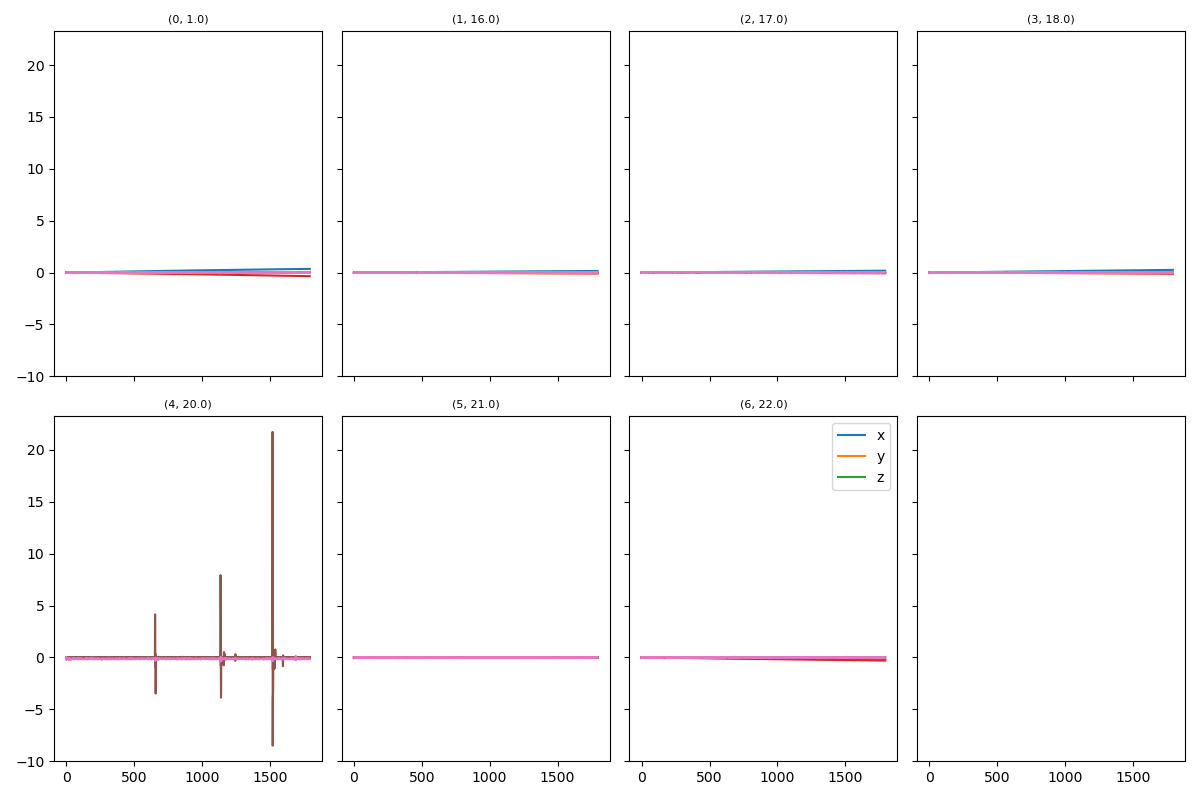

In [24]:
fig, axx = plt.subplots(int(np.ceil(header['n_items']/4)), 4, sharex=True, sharey=True, figsize=(12,8))

for i in range(header['n_items']):

    plt.sca(axx.reshape(-1)[i])

    target = frames[:, i, 1:8].copy()

    plt.plot(target - target[[0], :])

    plt.title((i, frames[0][i][0]), fontsize=8)

plt.legend(['x', 'y', 'z'])
plt.tight_layout()